# Projecte 3: Boosting Classifier Model

La sessió consisteix en crear un boosting classifier amb _decision trees_ de la llibreria sklearn com a _weak model_. 

Boosting (https://en.wikipedia.org/wiki/Boosting_(machine_learning)): tècnica d'aprenentatge automàtic que consiteix en entrenar múltiples models (_weak models_) seqüencialment per obtenir un model general _strong model_. Podem definir un _weak learner_ o _weak model_ com un classificador el qual està lleugerament correlacionat amb problema final i que és millor que intentar-ho encertar aleatòriament, és a dir, que no ha de veure tot el problema sener; considerem que un model weak learner si encerta entre el 55% i el 65% de bo. La idea és que cada _weak model_ es centra en una feature concreta o en arreglar els errors del classificador anterior.

En essència, el _boosting_ respon a la pregunta següent:

```Can a set of weak learners create a strong single learner? ```

La resposta a aquesta pregunta es **sí**, i ho veurem en aquesta sessió.

En el cas concret dels **classificadors** el que hem d'aconseguir és el següent: 
```
[...] most boosting algorithms consist of iteratively learning weak classifiers with respect to a distribution and adding them to a final strong classifier. When they are added, they are weighted in a way that is related to the weak learners' accuracy. After a weak learner is added, the data weights are readjusted, known as "re-weighting". Misclassified input data gain a higher weight and examples that are classified correctly lose weight.[note 1] Thus, future weak learners focus more on the examples that previous weak learners misclassified._
```

## Context

El dataset en qüestió (https://www.kaggle.com/datasets/anmolkumar/health-insurance-cross-sell-prediction) és un dataset d'assegurançes, el qual vol predir si els seus actuals clients estarien interessats en també adquirir una *assegurança de cotxe*. És a dir, de cilents ja existents d'una asseguradora, quina és la probabilitat de que els hi interessi adquirir una assegurança de cotxe per al seu vehicle. Anem a explorar el Dataset:

In [1]:
#Generate Baseline solution with a RandomForest
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('dataset/train_project3.csv')
print(df.shape)
df.head()

(304887, 12)


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,339630,Male,21,1,28.0,0,< 1 Year,Yes,44470.0,152.0,11,1
1,240794,Male,45,1,28.0,0,1-2 Year,Yes,2630.0,26.0,45,0
2,124429,Male,71,1,41.0,0,1-2 Year,Yes,2630.0,7.0,11,0
3,171989,Male,41,1,49.0,0,1-2 Year,Yes,36332.0,124.0,257,1
4,327313,Male,77,1,28.0,0,1-2 Year,Yes,42764.0,122.0,298,0


Fem una petita investigació de les classes de resposta

Total de zeros: 267573, percentual: 87.76%
Total de uns: 37314, percentual: 12.24%


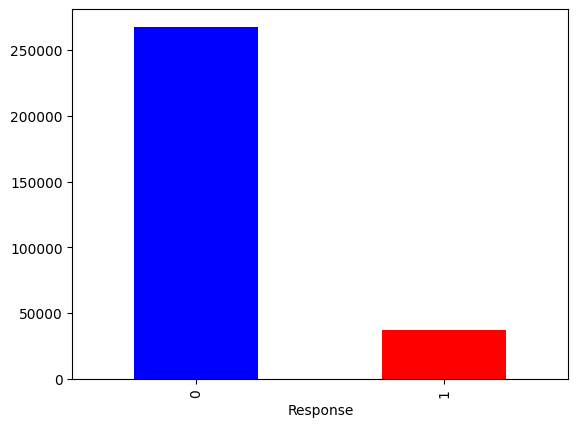

In [2]:
response = df["Response"].value_counts()
response.plot(kind='bar', color=['blue', 'red'])

zeros, ones = response[0]/df.shape[0], response[1]/df.shape[0]

print(f"Total de zeros: {response[0]}, percentual: {round(zeros,4)*100}%")
print(f"Total de uns: {response[1]}, percentual: {round(ones,4)*100}%")


És a dir, ens trobem davant del que es diu un dataset desequilibrat, o bé un _imabalanced dataset_, on hi ha moltes més observacions d'una classe o de l'altra. En general, aquest no és un cas ideal ja que pot portar a diferents problemes. Hi ha múltiples maneres de solucionar-ho, i a la pràctica us demanem que ho arregleu amb una _Weighted Binary Cross Entropy_

## Binary Cross Entropy o Log Loss

En binari ens referim al tipus de classifició entre dues classes. Per el model saber com de bé està classificant entre les dues classes, mira a l'espai n-dimensional de característiques com de lluny està el valor que ha donat a una observació. Aquesta "distància" és el que s'anomena la _loss function_, que en el cas de la classificació binària és

$L_B = -\cfrac{1}{N} \sum_{i=0}^N[y_i log(p_i) + (1-y_i)log(1-p_i)]$, on $N$ són les observacions, $y_i$ és el valor de veritat i $p_i$ és la probabilitat predita per la mostra $i$

Concretament (i com es desil·la de l'expressió) la formula calcula la pèrdua (com de lluny s'ha quedat la precció) comparant la probabilitat predita amb el valor real de l'observació, per tant, com més lluny està la predicció de la veritat, pitjor pèrdua té i més gran és el valor de la funció.

Transpira de l'explicació doncs, que si tenim moltes més mostres d'una classe que de l'altra el valor de la funció de pèrdua queda esbiaixat cap a la predicció d'una classe.

## Weighted Binary Cross Entropy

La idea és equilibrar el desbalançeig de mostres afegint un coeficient que faci que la pèrdua de la classe minoritària tingui més pes que no la de la classe majoritària:

$L_{WB} = -\cfrac{1}{N} \sum_{i=0}^N[w_1 y_i log(p_i) + w_0 (1-y_i)log(1-p_i)]; w_0 +w_1 = 1$

On $w_1$ és el pes de la classe majoritària i $w_0$ és el pes de la classe minoritària. El pesos han de ser inversament proporcionals a les freqüències de les classes, ergo tenint la classe minoritària (1) un pes més gran que la majoritària (0)


## Baseline

Una _baseline_ és una procediment de _benchmarking_ per comparar com el teu model funciona. Aquests han de ser senzills i ràpids d'implementar, i no tenen perque ser molt millors que endevinar aleatòriament la resposta. S'usen per comparar amb les modificacions que volem fer, de manera que vegem que el _boosting_ està millorant una aproximació ingènua dins de l'aprenentatge automàtic i per jutjar si val la pena!

In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# import data
train = pd.read_csv('dataset/train_project3.csv',)
test = pd.read_csv('dataset/test_project3.csv')

#train the model -> this is a baseline, only the simple features are used
model = RandomForestClassifier()
X = train[['Age','Driving_License','Annual_Premium','Vintage','Region_Code']]
y = train['Response']
model.fit(X,y)
y_train = model.predict(X)

accuracy = accuracy_score(y, y_train)
precision = precision_score(y, y_train)
recall = recall_score(y, y_train)
f1 = f1_score(y, y_train)
roc_auc = roc_auc_score(y, y_train)

# evaluate the test set
X_test = test[['Age', 'Driving_License', 'Annual_Premium', 'Vintage', 'Region_Code']]
y_test = model.predict(X_test)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")
print(f"ROC AUC: {roc_auc}")


Accuracy: 0.9966610580313362
Precision: 0.9951705320600273
Recall: 0.9774615425845528
F1: 0.9862365475095992
ROC AUC: 0.9884000204317636


In [4]:
# save our predictions in the Kaggle formats
test['Response'] = y_test
test[['id','Response']].to_csv('my_solution.csv',index=None)

# Tasques

1. Completeu la classe _BoostingClassifier_ i els seus dos mètodes _fit_ i _predict_ com veieu més adhient per obtenir els millors resultats al Dataset.
2. Implementeu la funció *balance_weights* per veure quin pes assigna a cada vector.

La idea és que trobeu quin calcul d'error, quin learning rate i quin estil de predicció dona millors resultats, també com quin repartiment de pesos balançeja millor el dataset. 

NOTA: per a que el resultat sigui el millor possible podeu tractar el dataset amb les eines apreses a les sessions 1 i 2 (tractament de categòriques, mirar correlacions, estratificar el train i test...).

3. Penjeu els millors resultats al Kaggle!


In [5]:
from sklearn.tree import DecisionTreeClassifier
import numpy as np

class BoostingClassifier:
    def __init__(self, X: np.array, y: np.array, w: np.array):
        self.X = X
        self.y = y
        self.weights = w / w.sum()  # Normalize initial weights
        self.n = X.shape[0]
        self.trees = []  # Store weak learners
        self.learning_rates = []
        #self.predictions = [] # es poden guardar les prediccions en comptes dels arbres

    def fit(self, num_trees, shrinkage=1.0, factor=1.0):
        for m in range(num_trees):
            # Train weak learner
            tree = DecisionTreeClassifier(max_depth=2)
            tree.fit(self.X, self.y, sample_weight=self.weights)
            predictions = tree.predict(self.X)
            
            """
            TODO:
            1. Calcular les mostres mal classificades
            2. Calcular l'error de l'arbre
            3. Actualitzar els pesos segons la predicció d'aquesta iteració
            4. Calcular el Learning Rate
            5. Guardar les variables
            """

    def predict(self, X):
        """
        TODO: MÈTODE QUE AJUNTI LES PREDICCIONS DELS ARBRES AMB UNA COMBINACIÓ LINEAL DELS PESOS.
        """
        return result


def balance_weights(responses: list[int]):
    """
    Assignates different weights depending on the class

    Args:
        responses binary vector
    
    Returns:
        list[float] with numbers between zero and one being the starting weight
    """
    return balanced

In [6]:
# A EXECUTAR QUAN ESTIGUI FET

X_train, X_test, y_train, y_test = sklearn.train_test_split(X, y, test_size=0.4)

initial_weights = balance_weights(y_train)

bc = BoostingClassifier(X_train, y_train, initial_weights)
bc.fit(15, shrinkage=0.1, factor = 1.55)
result = bc.predict(X_train)

result = bc.predict(X_test)

AttributeError: module 'sklearn' has no attribute 'train_test_split'

# Preguntes
Per acabar, contesteu les següents preguntes:
1. Quines mètriques heu fet servir per avaluar els models? Com depenen aquestes mètriques segons el balanç del model?
2. Prova d'inicialitzar el model amb els pesos a $1/n$. Hi ha diferència entre pesos uniformes o cambiants per classe?
3. Descriu breument l'estratègia d'actualitzar pesos, calcul d'errors, calcul de learning rate i predicció final. Investiga quines són les estratègies que utilitza el model AdaBoost i discuteix com de similars són les teves.
4. Compara els resultats amb els següents models de baseline: RandomForest, Bagging i AdaBoost.

# --- Respostes Preguntes ---
1.
2.
3.

## Entrega: 8 de Desembre de 2024, 23:59